In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import root_pandas as rp
import pandas as pd
from tqdm import tqdm
from scipy.special import erfc

from scipy.optimize import curve_fit

Welcome to JupyROOT 6.22/00


In [2]:
def model(x, a, b, c):
    """
    a => sigma_l + sigma_t
    b => epsilon*sigma_tt
    c => Sqrt(2epsilon(1+epsilon))* sigma_lt
    """
    f = a + b * np.cos(2*x) + c * np.cos(x)
    return f

def degauss(x, A, mu, sigma, lambda1, lambda2):
    mu1 = sigma * sigma * lambda1 + x - mu
    mu2 = -sigma * sigma * lambda2 + x - mu
    ret = A * 0.5 / (1.0 / lambda1 + 1.0 / lambda2) * \
        (np.exp(0.5 * np.power(sigma * lambda1, 2) + lambda1 * (x - mu)) * erfc(mu1 / (sigma * np.sqrt(2.0))) \
         + np.exp(0.5 * np.power(sigma * lambda2, 2) - lambda2 * (x - mu)) * erfc(-mu2 / (sigma * np.sqrt(2.0))))

    return ret

def gauss(x, A, mu, sig):
    ret = np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    return A*ret

def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = np.max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]


In [3]:
#df = pd.read_csv("test.csv",index_col=False)
#df = pd.read_csv("all.csv", index_col=False)
df = pd.read_csv("/Users/tylern/physics_code/build/test_mc.csv", index_col=False)
    
df = df[(df.w > 0) & (df.mm2 > 0.5) & (df.mm2 < 1.5)]
df['cos_theta'] = np.cos(df.theta)
#df = df[np.abs(df.helicty) == 1]
print(len(df))
df = df[df.type == "mc_rec"]
df.head()

3726614


,electron_sector,w,q2,theta,phi,mm2,e_p,e_cx,e_cy,e_cz,pip_p,pip_cx,pip_cy,pip_cz,helicty,type,cos_theta
29712,1,1.517518,3.455450,1.875311,4.108688,0.885597,2.217824,0.521540,0.158973,0.838286,0.805973,-0.446309,-0.596841,0.666775,-1,mc_rec,-0.299830
29713,4,1.513885,2.715426,0.751161,1.950872,0.950231,2.618047,-0.449140,-0.044632,0.892346,1.492096,0.502729,-0.132447,0.854237,1,mc_rec,0.730897
29715,4,1.519211,2.530771,0.731911,2.540228,0.887706,2.707839,-0.429074,-0.022313,0.902994,1.530091,0.583107,-0.081728,0.808274,1,mc_rec,0.743899
29716,1,1.309690,1.481363,2.148832,4.793473,0.879335,3.582917,0.283870,-0.058339,0.957086,0.297081,-0.439299,-0.756703,0.484167,-1,mc_rec,-0.546380
29717,1,1.633559,1.470095,1.823098,2.221970,0.898797,3.080953,0.310720,-0.007195,0.950474,0.711699,-0.689619,0.589198,0.421035,1,mc_rec,-0.249633


In [4]:
def mm_cut(df):
    NSIGMA = 3
    data = []
    for sec in range(1,7):
        plt.figure(figsize=(12,9))
        y,x = np.histogram(df[df.electron_sector == sec].mm2, bins=500, density=True)
        x=(x[1:]+x[:-1])/2
        popt_g, pcov_g = curve_fit(gauss,x,y, maxfev=8000)
        plt.plot(x, gauss(x,*popt_g), linewidth=2.0)
        plt.errorbar(x,y,yerr=np.sqrt(y.shape[0])/y.shape[0], fmt='.', zorder=1)

        plt.axvline(popt_g[1]+NSIGMA*popt_g[2])
        plt.axvline(popt_g[1]-NSIGMA*popt_g[2])
        
#         p0 = [popt_g[0],popt_g[1],popt_g[2], 1.0,1.0]
#         popt, pcov = curve_fit(degauss,x,y, maxfev=8000)
        
#         plt.plot(x, degauss(x,*popt), c='#9467bd', linewidth=2.0)
        
#         # find the FWHM
#         xs= np.linspace(0.7,1.5,100000)
#         hmx = half_max_x(xs, degauss(xs,*popt))
#         fwhm = hmx[1] - hmx[0]
#         plt.axvline(popt[1]+NSIGMA*fwhm/2.355, c='#9467bd')
#         plt.axvline(popt[1]-NSIGMA*fwhm/2.355, c='#9467bd')
        
        plt.show()

        data.append(df[(df.electron_sector == sec)
                       &(df.mm2 <= popt_g[1]-NSIGMA*popt_g[2])
                       &(df.mm2 >= popt_g[1]+NSIGMA*popt_g[2])])
        
        print('{', end='')
        for x in popt_g:
            print(f' {x:.20f},', end='')
        print('}')

    return data

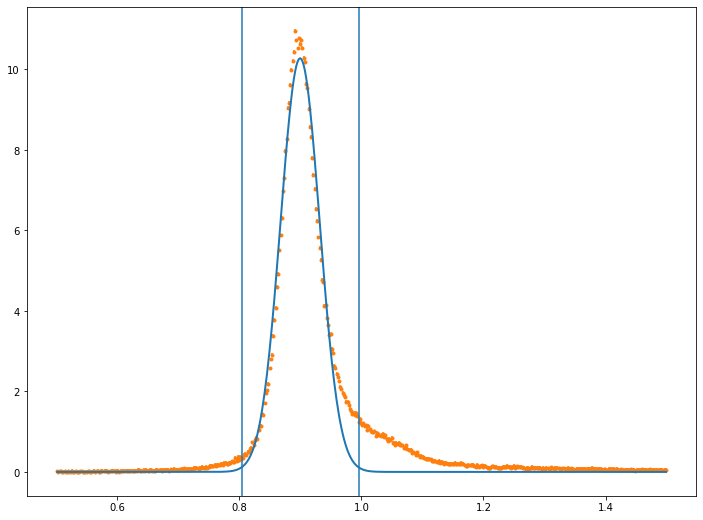

{ 10.27634724003405253256, 0.89969825096094291350, -0.03194077245515471175,}


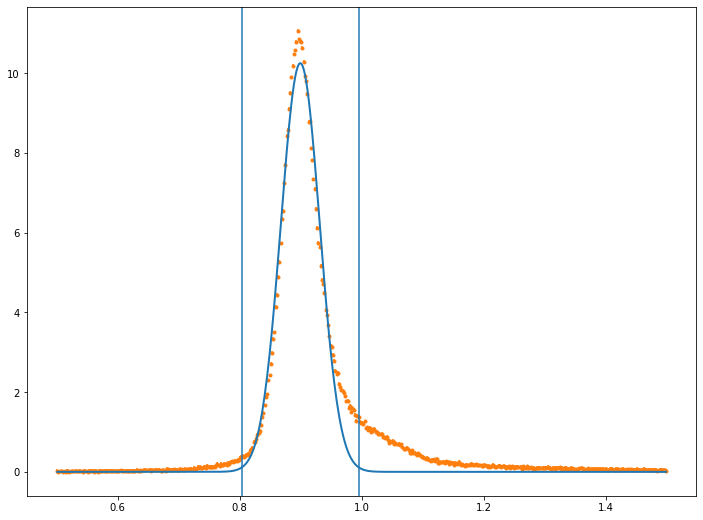

{ 10.24902966927560754584, 0.89941614268379466157, -0.03188274988164624402,}


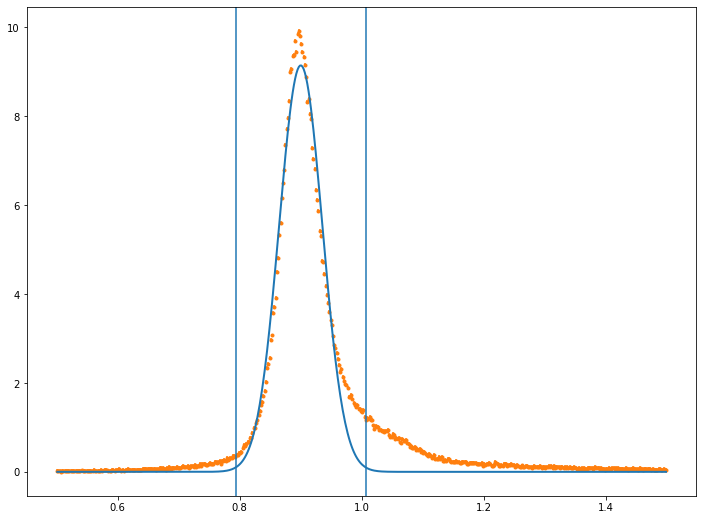

{ 9.14176990994860894091, 0.90018544765010377606, -0.03544861074823011521,}


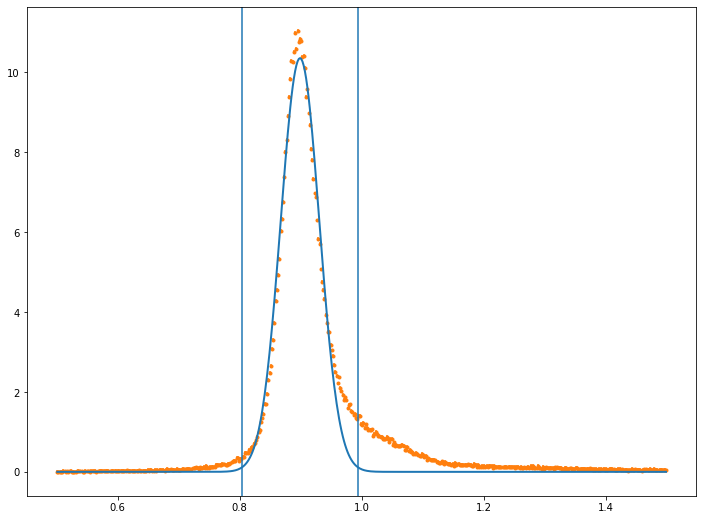

{ 10.35884158477313654600, 0.89896607106852588487, -0.03162665099565477311,}


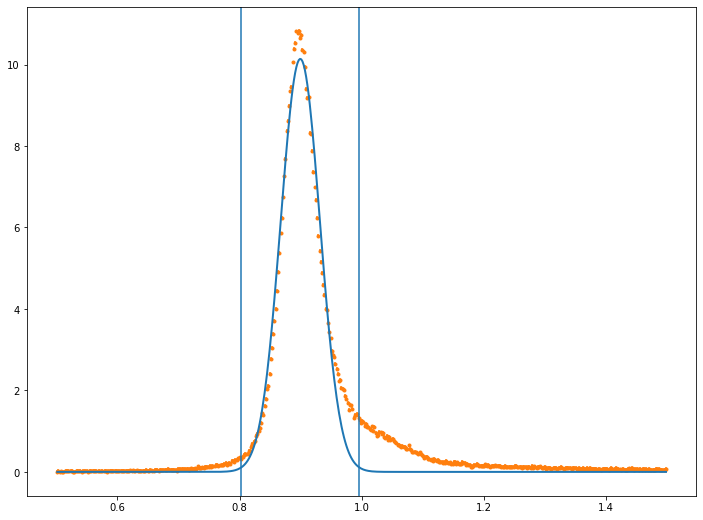

{ 10.13944559835127101621, 0.89959855714203851296, -0.03215182353460683401,}


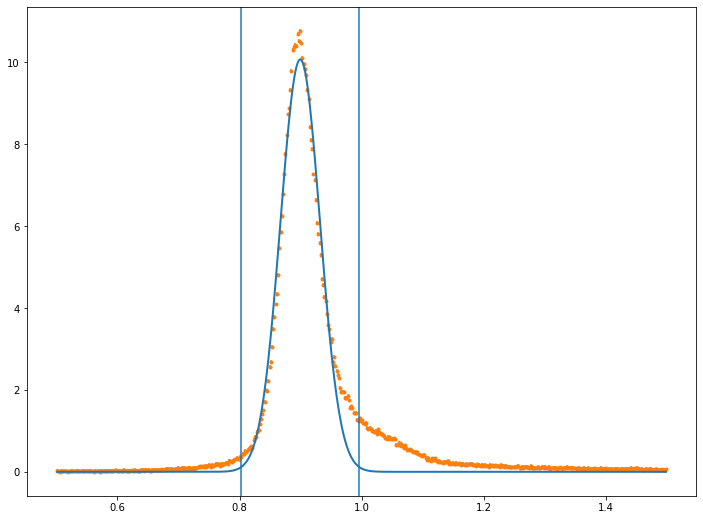

{ 10.06594728574498454066, 0.89947661651318056020, -0.03238213908759064730,}


In [5]:
data = mm_cut(df)
all_data = pd.concat(data)

No handles with labels found to put in legend.


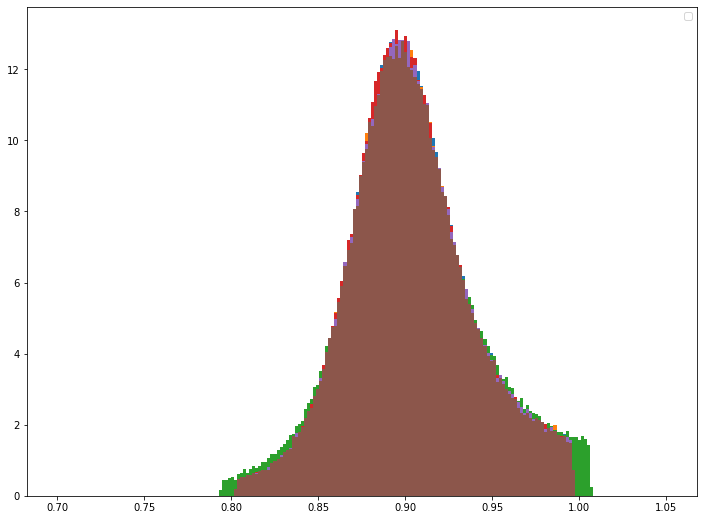

In [6]:
plt.figure(figsize=(12,9))
for i in range(0,6):
    #y, x = np.histogram(data[i].mm2, bins=200, density=False, range=(0.2, 1.0))
    y, x = np.histogram(data[i].mm2, bins=200, density=True, range=(0.7, 1.05))
    x = (x[1:]+x[:-1])/2
    plt.hist(data[i].mm2, bins=200, density=True, range=(0.7, 1.05))
    #plt.scatter(x[y!=0], y[y!=0], label=f'sector {i+1}')
plt.legend()
plt.show()

In [7]:
all_data.head()

,electron_sector,w,q2,theta,phi,mm2,e_p,e_cx,e_cy,e_cz,pip_p,pip_cx,pip_cy,pip_cz,helicty,type,cos_theta
29712,1,1.517518,3.455450,1.875311,4.108688,0.885597,2.217824,0.521540,0.158973,0.838286,0.805973,-0.446309,-0.596841,0.666775,-1,mc_rec,-0.299830
29716,1,1.309690,1.481363,2.148832,4.793473,0.879335,3.582917,0.283870,-0.058339,0.957086,0.297081,-0.439299,-0.756703,0.484167,-1,mc_rec,-0.546380
29717,1,1.633559,1.470095,1.823098,2.221970,0.898797,3.080953,0.310720,-0.007195,0.950474,0.711699,-0.689619,0.589198,0.421035,1,mc_rec,-0.249633
29727,1,1.938136,3.313221,0.140536,1.912959,0.910550,1.519050,0.633462,-0.015702,0.773615,3.009533,-0.265456,0.038417,0.963357,1,mc_rec,0.990141
29732,1,1.897485,1.822431,1.575592,1.310807,0.916726,2.396572,0.388565,-0.025361,0.921072,1.248275,-0.108071,0.548968,0.828827,1,mc_rec,-0.004796


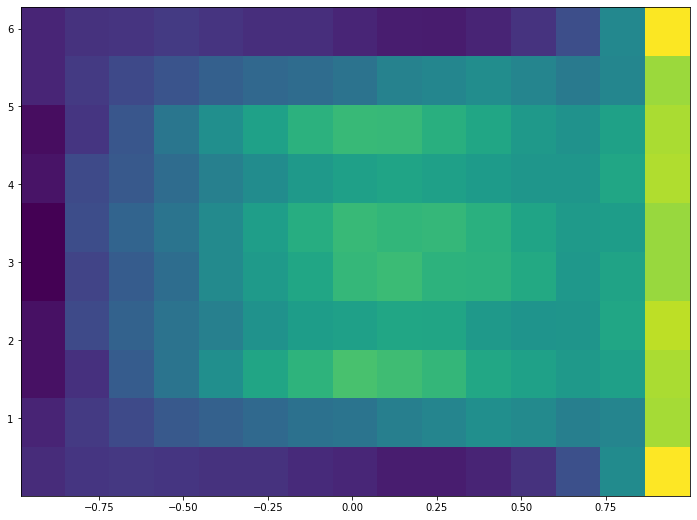

In [8]:
plt.figure(figsize=(12,9))
plt.hist2d(all_data.cos_theta, all_data.phi, bins=(15,10))
plt.show()

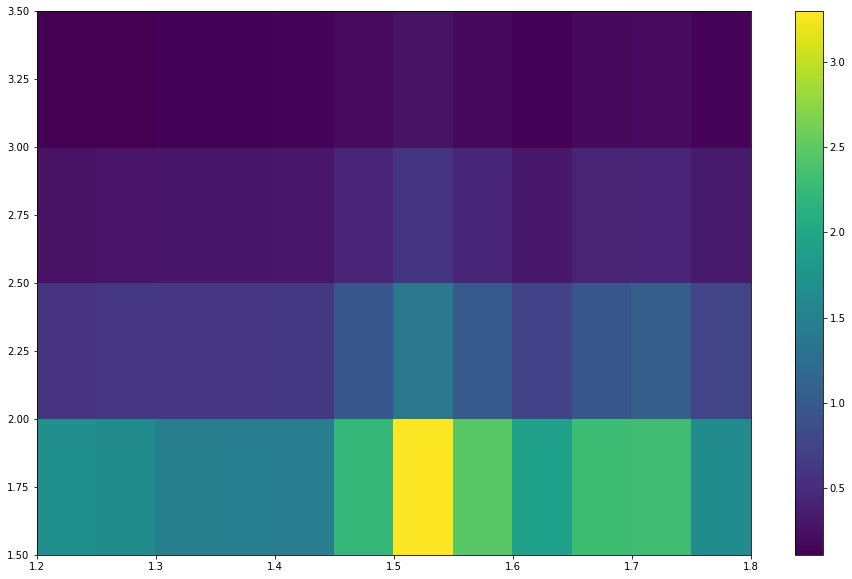

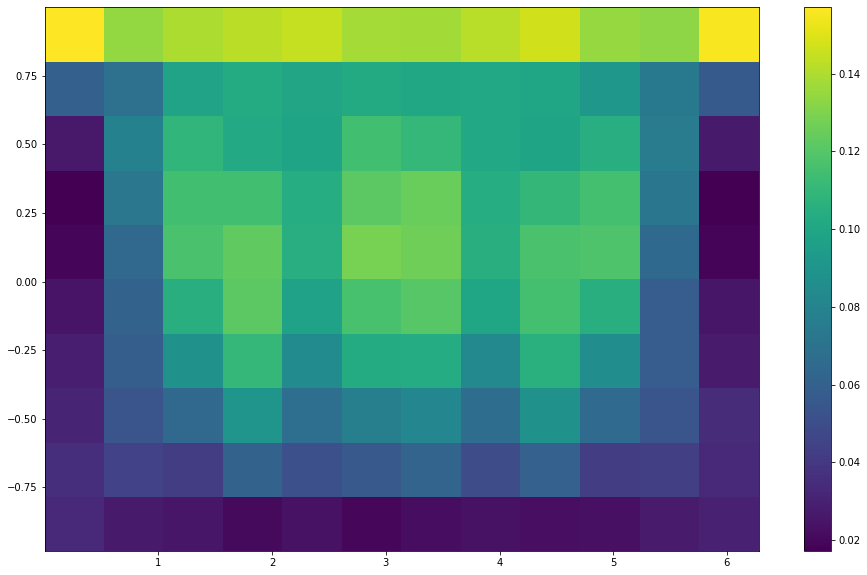

In [9]:
NUM_BINS_W = 12
NUM_BINS_Q2 = 4
NUM_BINS_PHI = 12
NUM_BINS_CT = 10

W_MIN = 1.2
W_MAX = 1.8
Q2_MIN = 1.5
Q2_MAX = 3.5



plt.figure(figsize=(16,10))
counts, w_bins, q2_bins, mesh = plt.hist2d(all_data.w,all_data.q2, 
                                           bins=(NUM_BINS_W, NUM_BINS_Q2), 
                                           range=((W_MIN, W_MAX),(Q2_MIN, Q2_MAX)), 
                                           density=True)
plt.colorbar()
plt.show()

plt.figure(figsize=(16,10))
counts, phi_bins, theta_bins, mesh = plt.hist2d(all_data.phi, all_data.cos_theta, 
                                                bins=(NUM_BINS_PHI, NUM_BINS_CT), 
                                                density=True)
plt.colorbar()
plt.show()

In [10]:
cross_sections = df[["w","q2","cos_theta","phi","helicty"]].copy(deep=True)

In [11]:
cross_sections = df[["w","q2","cos_theta","phi","helicty"]].copy(deep=True)
w_bins = np.arange(1.2, 1.8, 0.025)
q2_bins = np.arange(1.0, 3.5, 0.5)
theta_bins = np.arange(-1.0, 1.0, 0.25)


cross_sections['w_bin'] = pd.cut(cross_sections['w'], bins=w_bins, include_lowest=True)
cross_sections['q2_bin'] = pd.cut(cross_sections['q2'], bins=q2_bins, include_lowest=True)
cross_sections['theta_bin'] = pd.cut(cross_sections['cos_theta'], bins=theta_bins, include_lowest=True)



cross_sections.dropna(inplace=True)

cross_sections.head()

,w,q2,cos_theta,phi,helicty,w_bin,q2_bin,theta_bin
29713,1.513885,2.715426,0.730897,1.950872,1,"(1.5, 1.525]","(2.5, 3.0]","(0.5, 0.75]"
29715,1.519211,2.530771,0.743899,2.540228,1,"(1.5, 1.525]","(2.5, 3.0]","(0.5, 0.75]"
29716,1.309690,1.481363,-0.546380,4.793473,-1,"(1.3, 1.325]","(0.999, 1.5]","(-0.75, -0.5]"
29717,1.633559,1.470095,-0.249633,2.221970,1,"(1.625, 1.65]","(0.999, 1.5]","(-0.25, 0.0]"
29719,1.510309,2.049152,-0.483331,4.515408,1,"(1.5, 1.525]","(2.0, 2.5]","(-0.5, -0.25]"


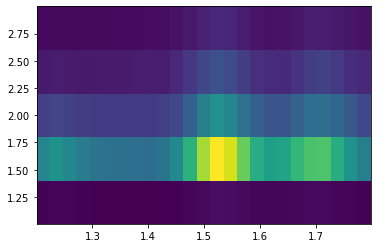

In [12]:
plt.hist2d(cross_sections.w,cross_sections.q2,bins=(len(w_bins),len(q2_bins)))
plt.show()

In [13]:
pos = cross_sections[cross_sections.helicty == 1]
print(len(pos))
neg = cross_sections[cross_sections.helicty == -1]
print(len(neg))
noh = cross_sections[cross_sections.helicty == 0]

print(len(noh))

493524
494389
0


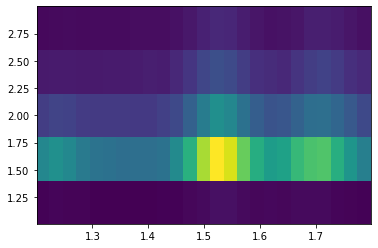

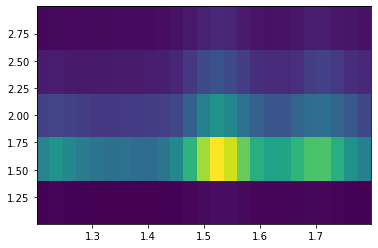

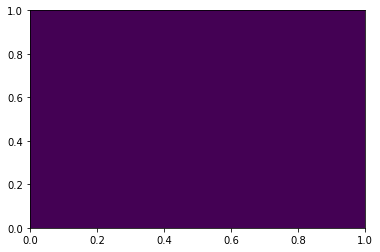

In [14]:
plt.hist2d(pos.w,pos.q2,bins=(len(w_bins),len(q2_bins)))
plt.show()

plt.hist2d(neg.w,neg.q2,bins=(len(w_bins),len(q2_bins)))
plt.show()

plt.hist2d(noh.w,noh.q2,bins=(len(w_bins),len(q2_bins)))
plt.show()

In [15]:
def draw_xsection(cross_sections, func):
    for w in np.unique(cross_sections.w_bin)[:2]:
        for q2 in np.unique(cross_sections.q2_bin):
            for cos_t in np.unique(cross_sections.theta_bin):
                fig = plt.figure(figsize=(12,9))
                data = cross_sections[(w == cross_sections.w_bin) 
                              & (q2 == cross_sections.q2_bin)
                              & (cos_t == cross_sections.theta_bin)]
                y, x = np.histogram(data.phi, bins=10, range=(0, 2*np.pi))
                x = (x[1:]+x[:-1])/2.0

                popt, pcov = curve_fit(func, x, y, maxfev=8000)
                plt.errorbar(x, y, yerr=np.sqrt(y)/len(y), marker='*', linestyle='', zorder=1)
                xs = np.linspace(0,2*np.pi,100)
                plt.plot(xs, func(xs, *popt), c='#9467bd', linewidth=2.0)
                plt.title(f"W={w}, $Q^2$={q2}, cos($\Theta$)={cos_t}")
                #plt.ylim(-5, 100)
                plt.show()
                #plt.close()


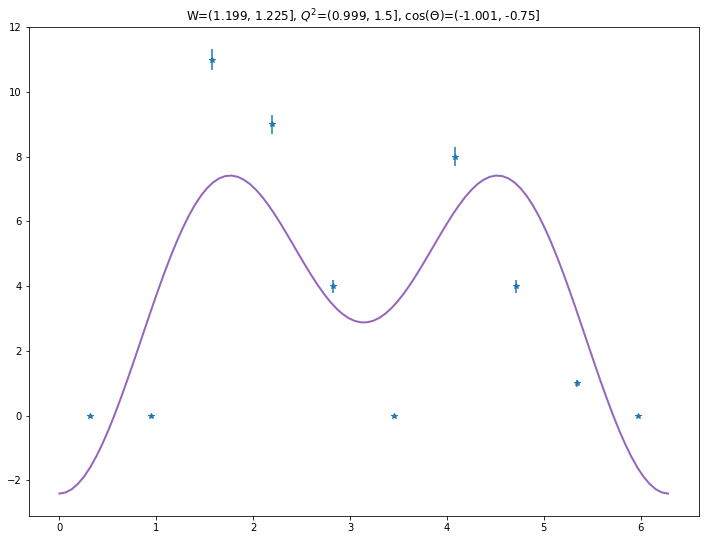

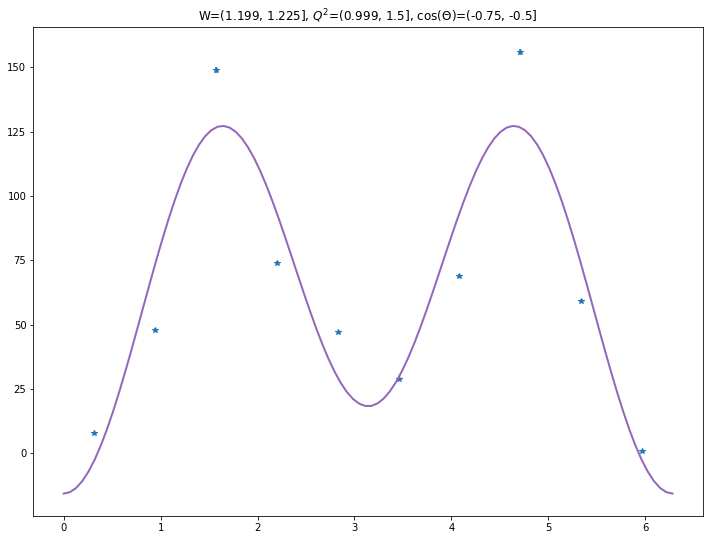

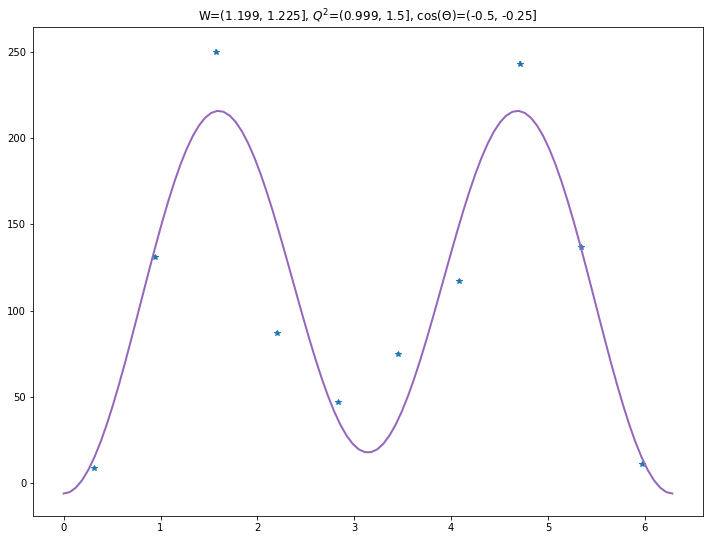

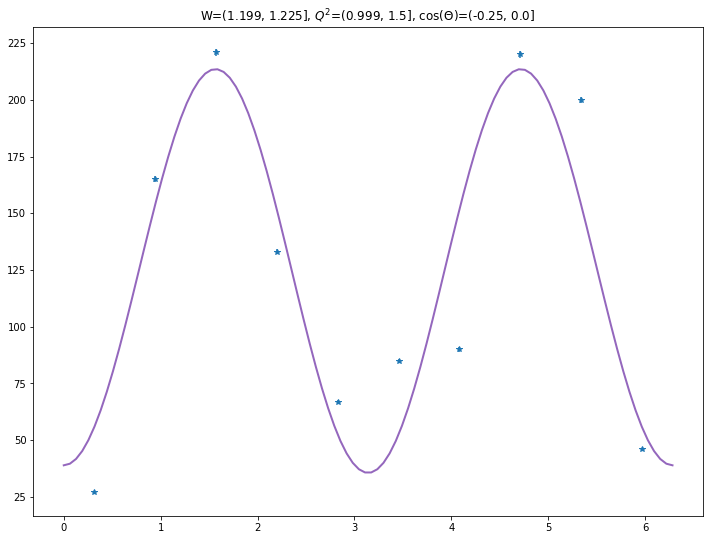

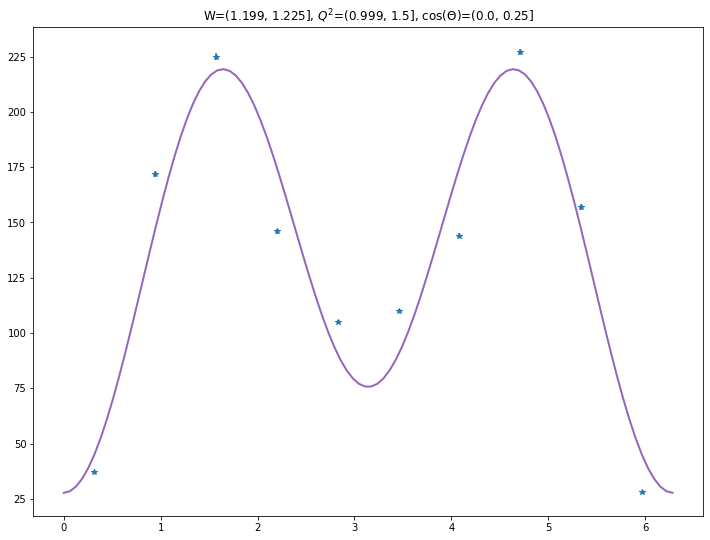

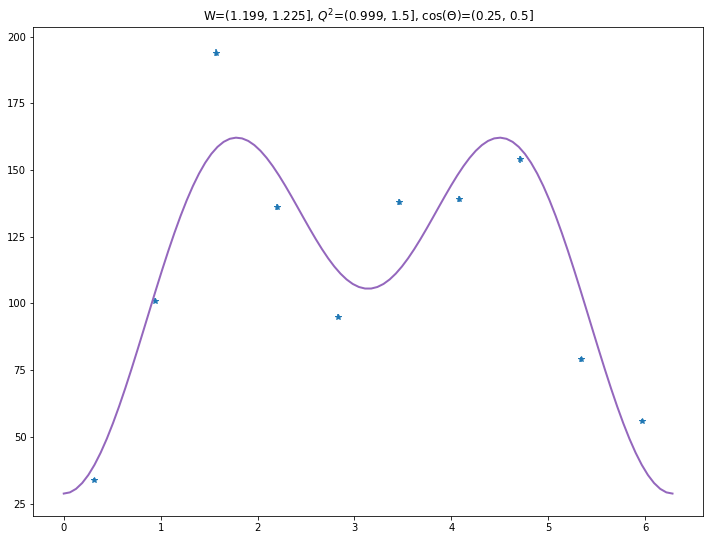

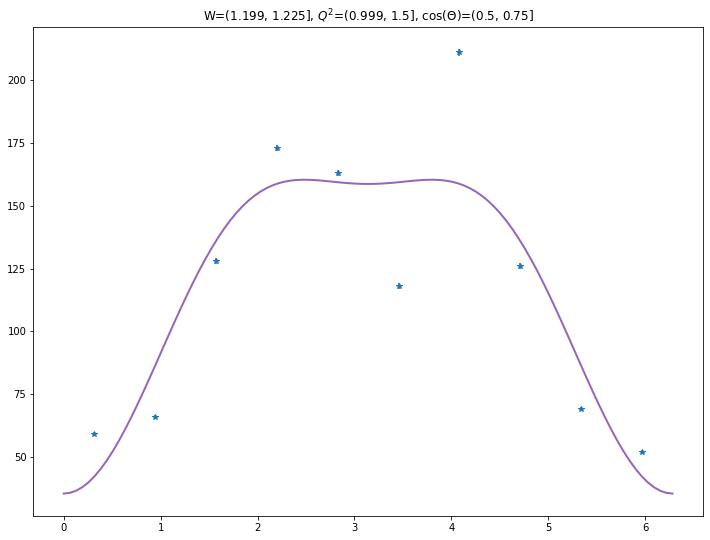

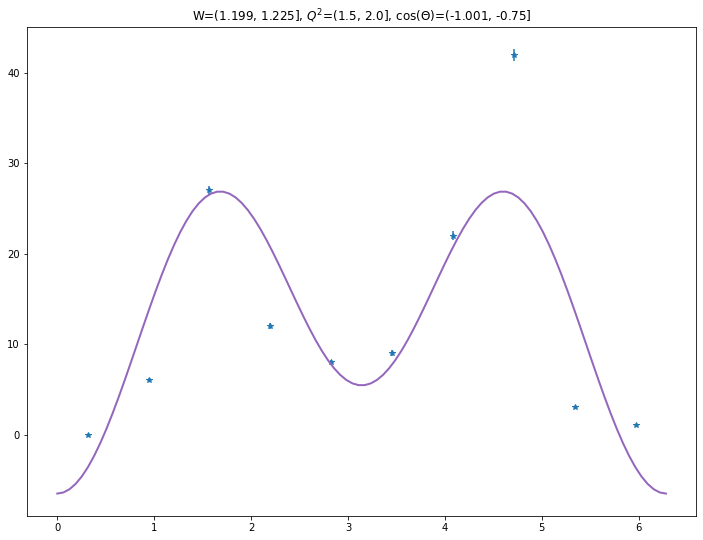

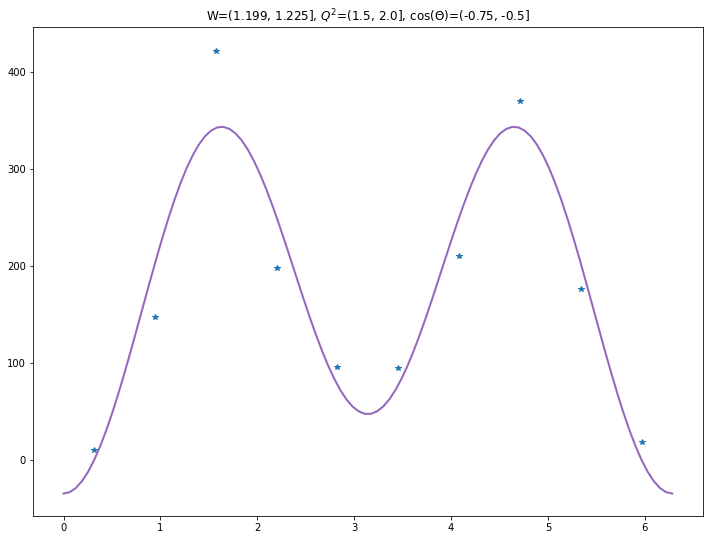

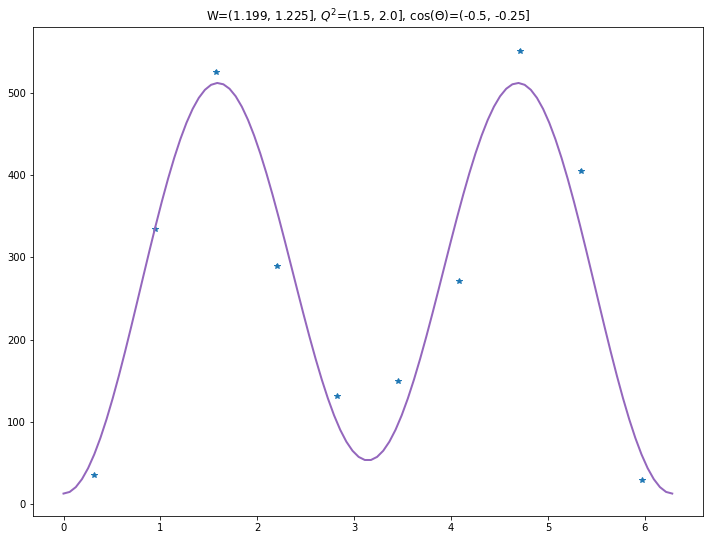

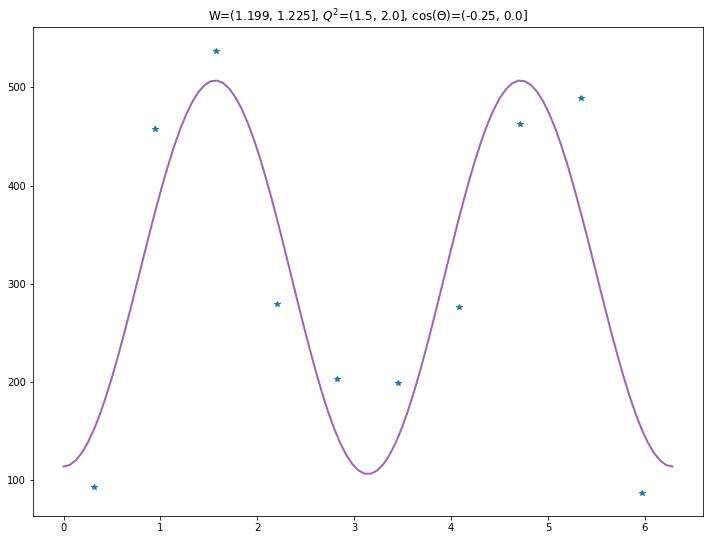

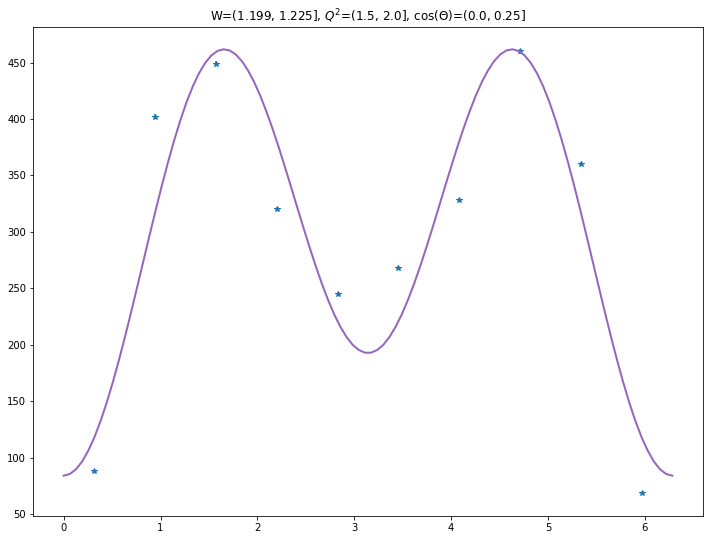

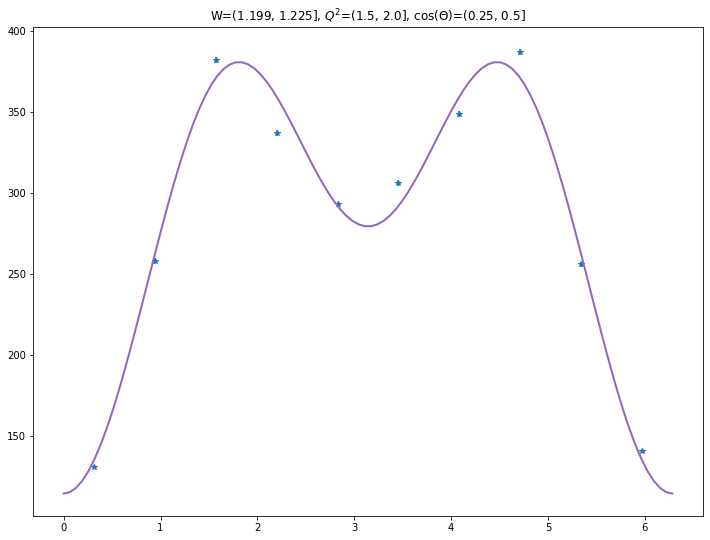

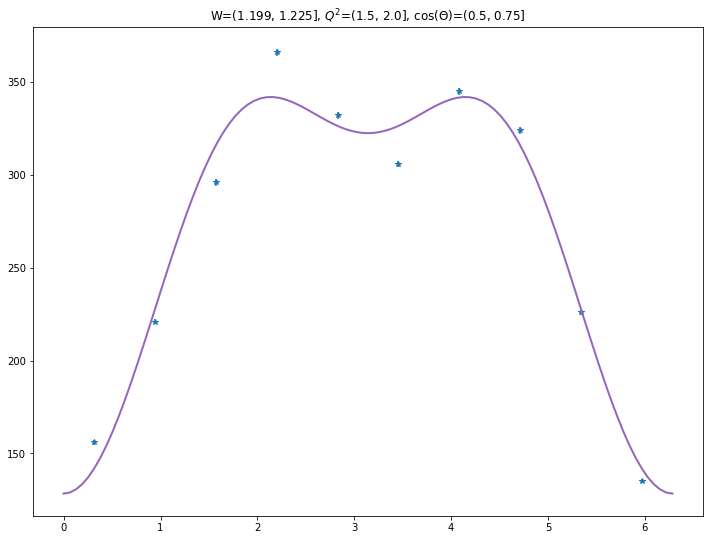

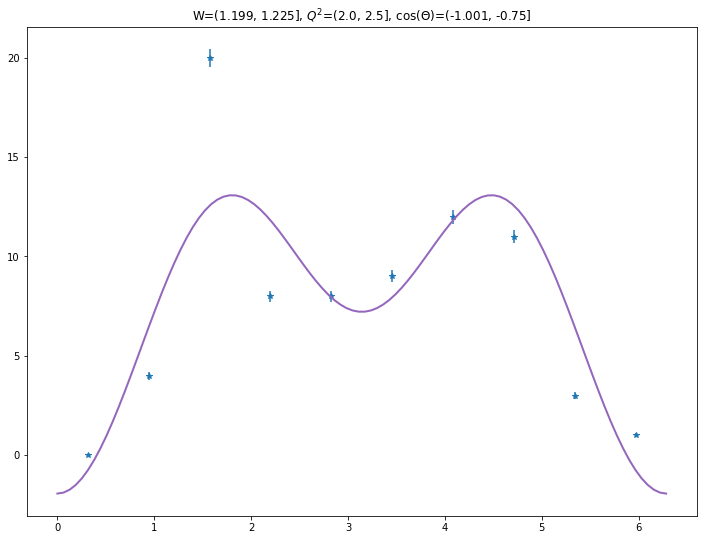

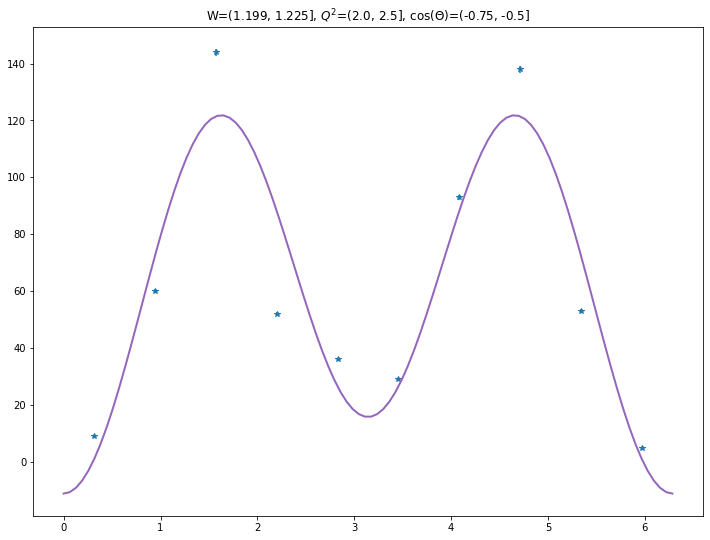

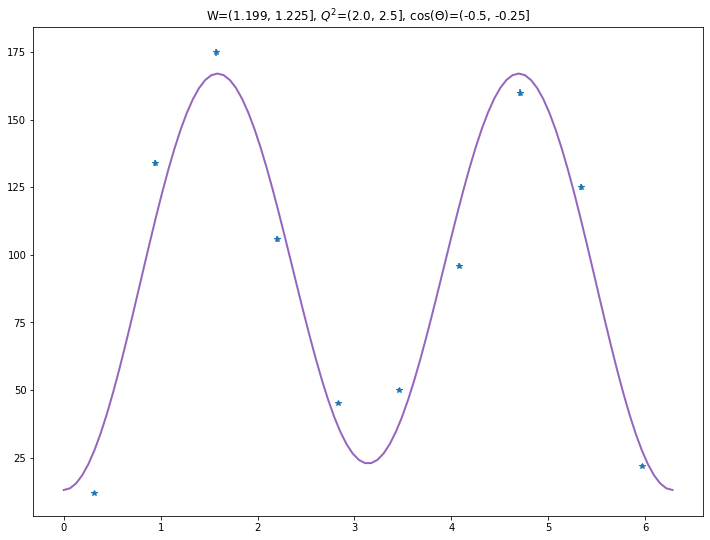

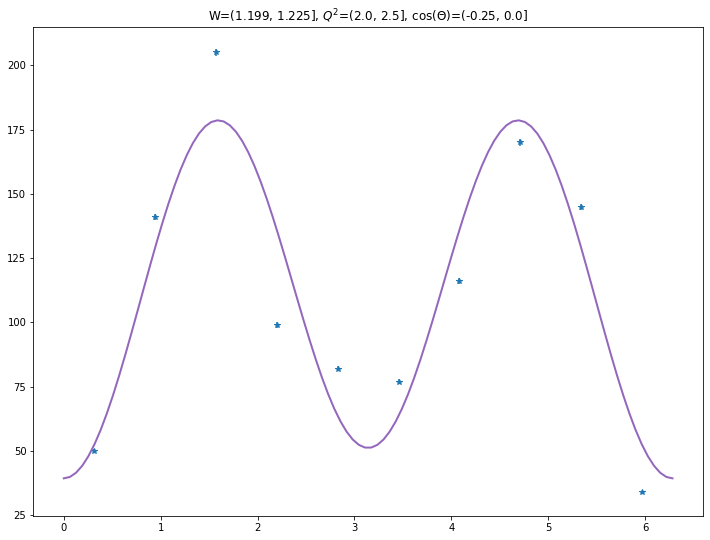

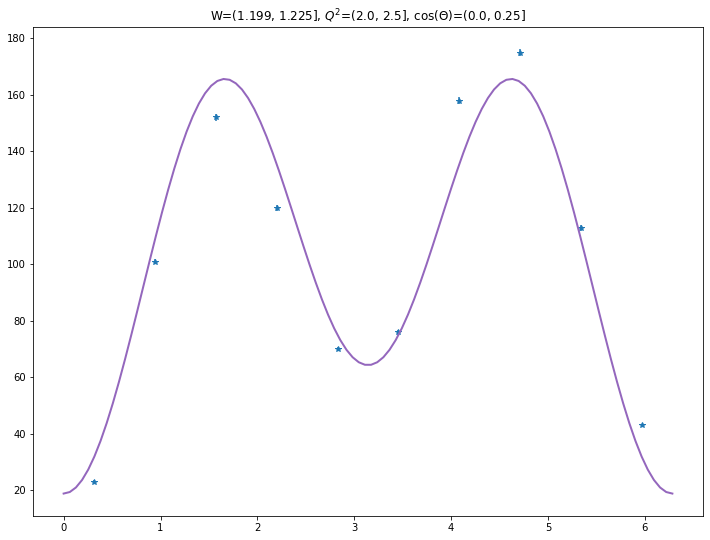

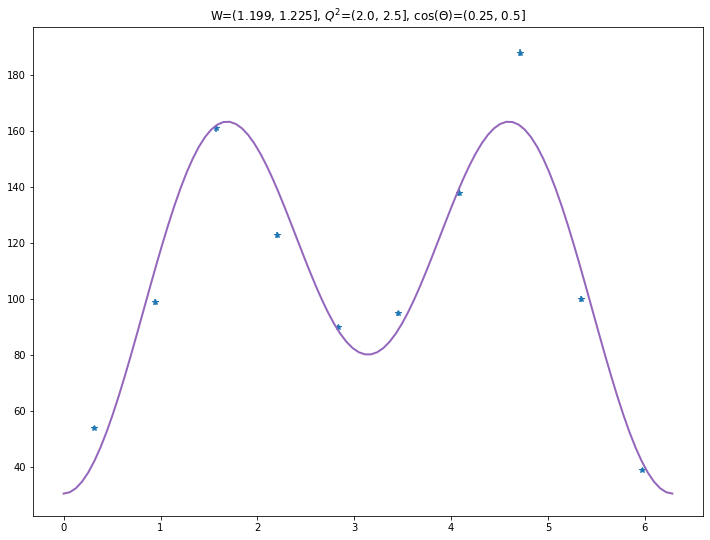

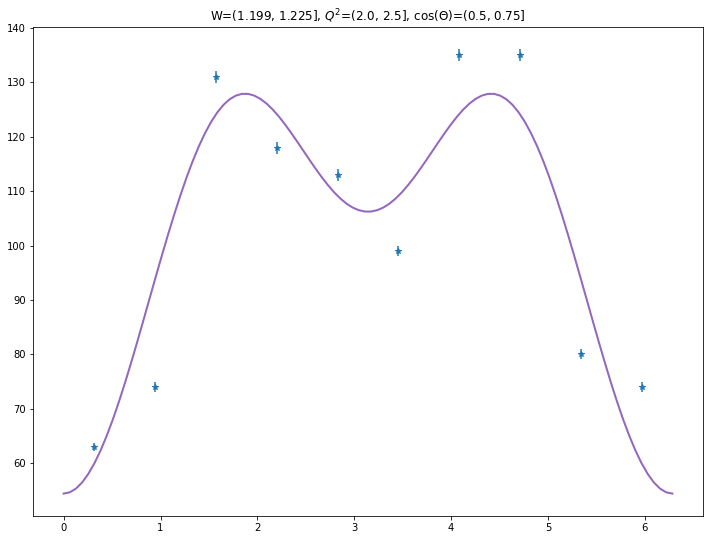

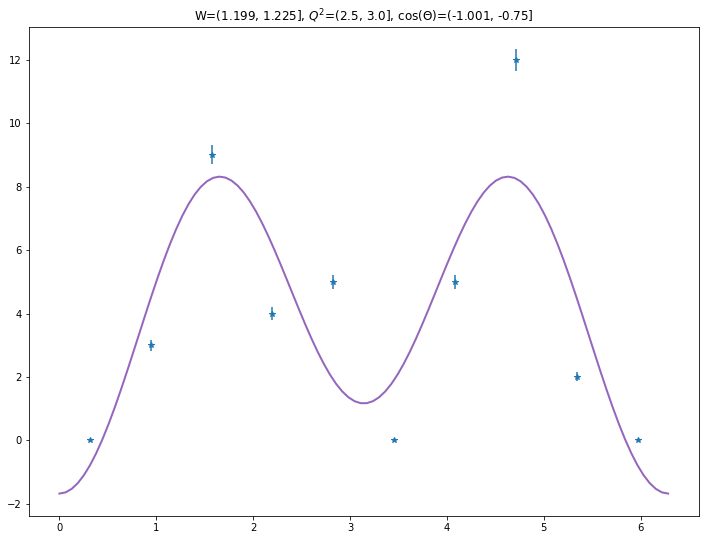

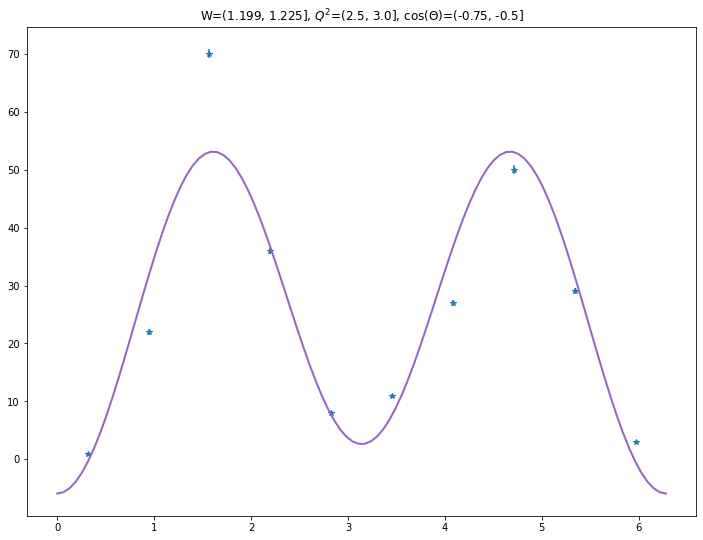

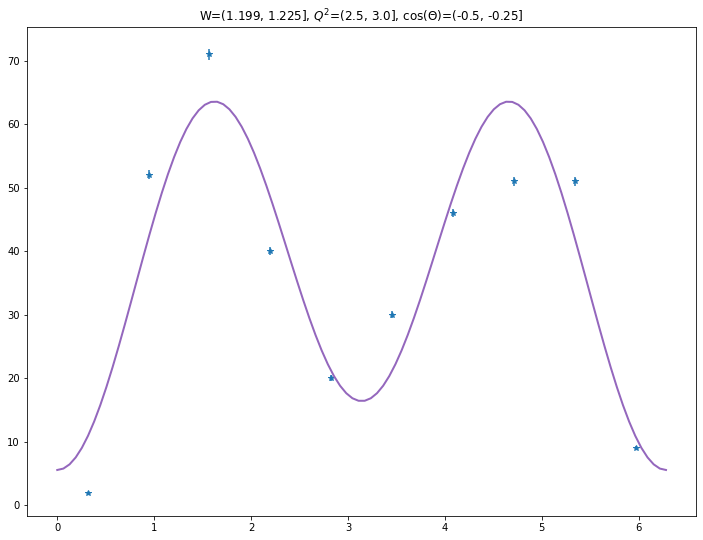

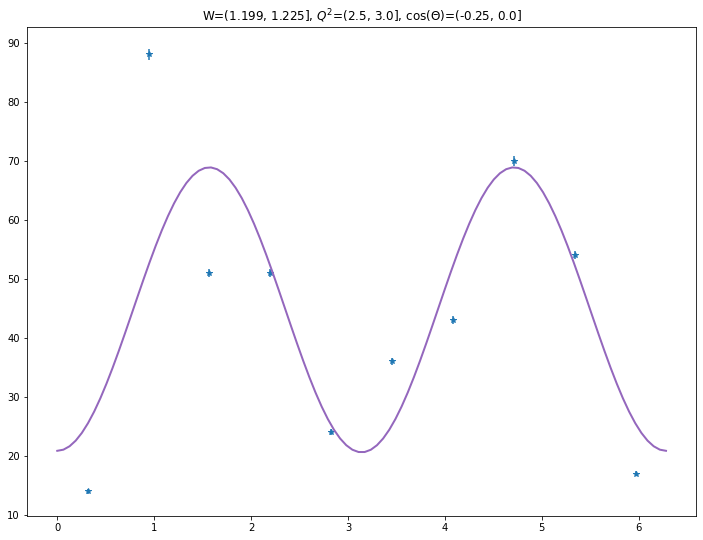

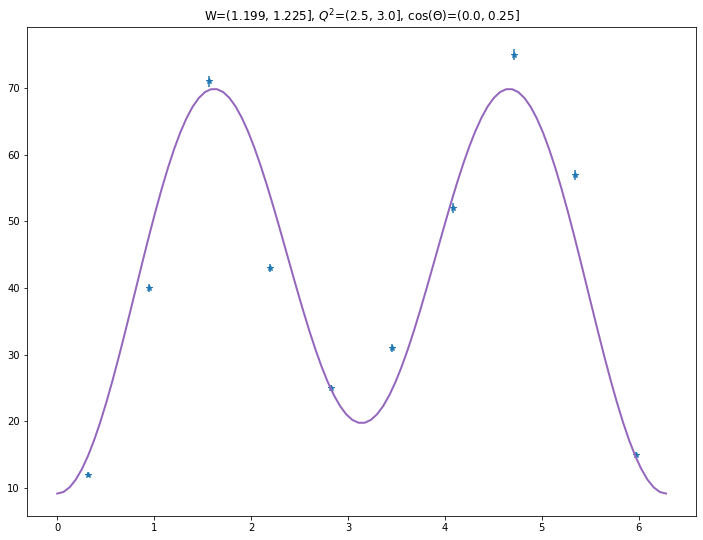

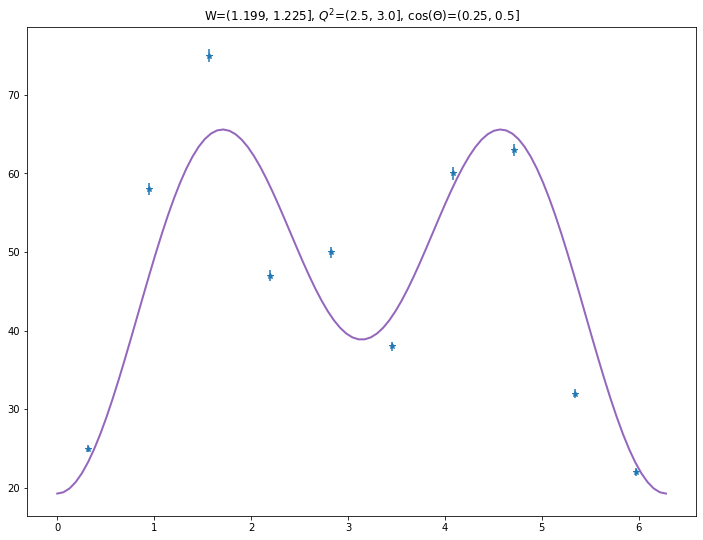

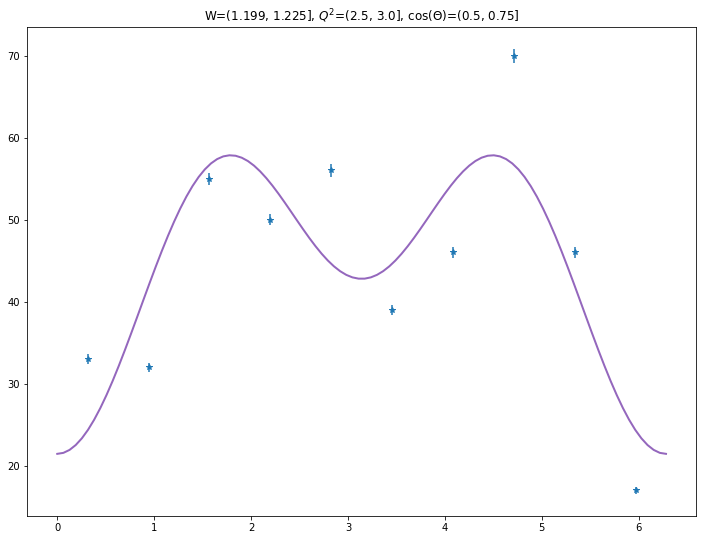

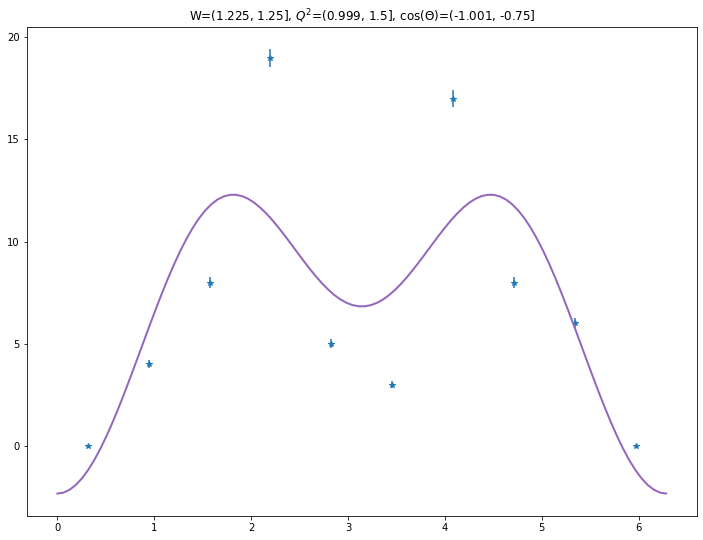

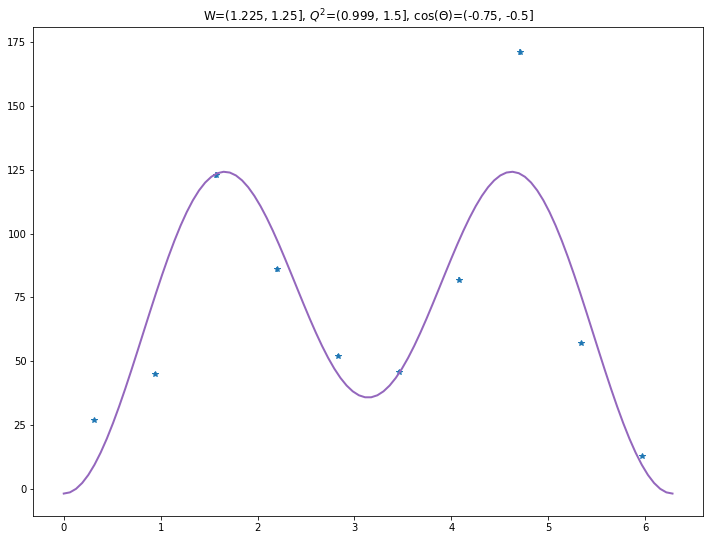

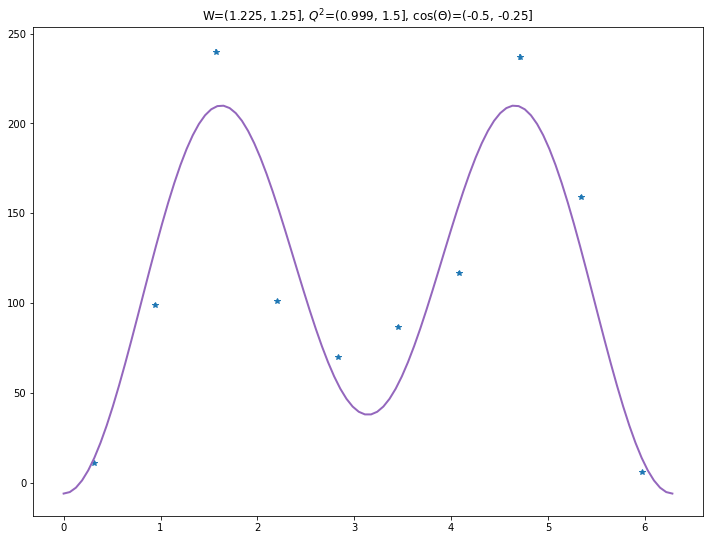

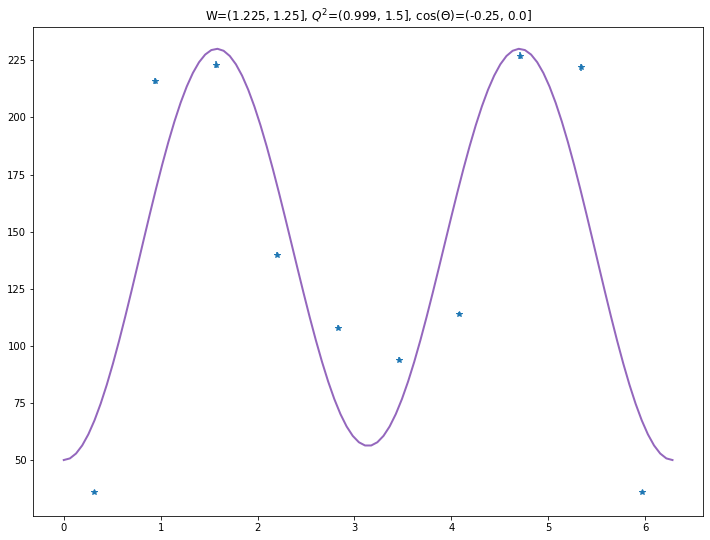

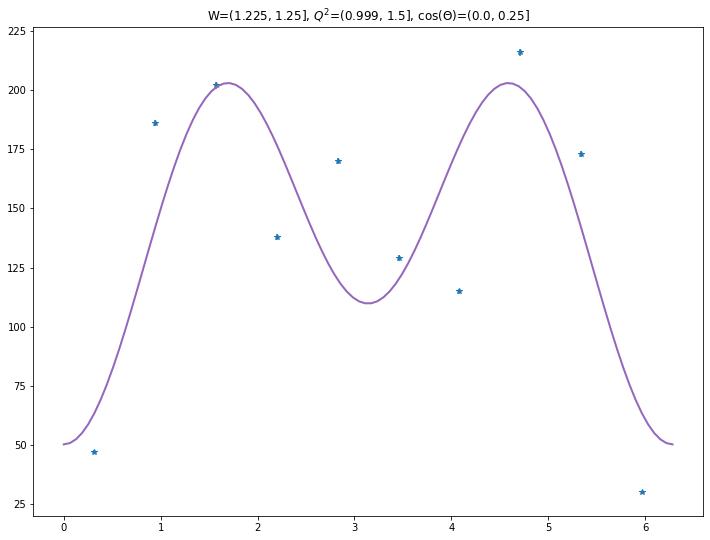

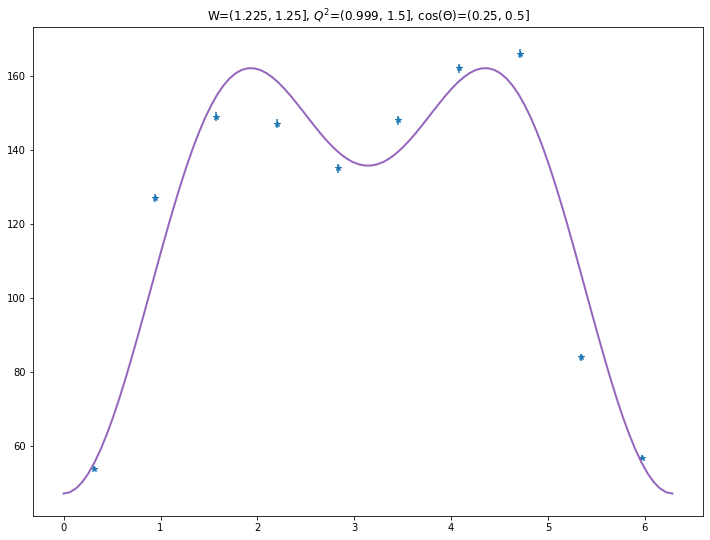

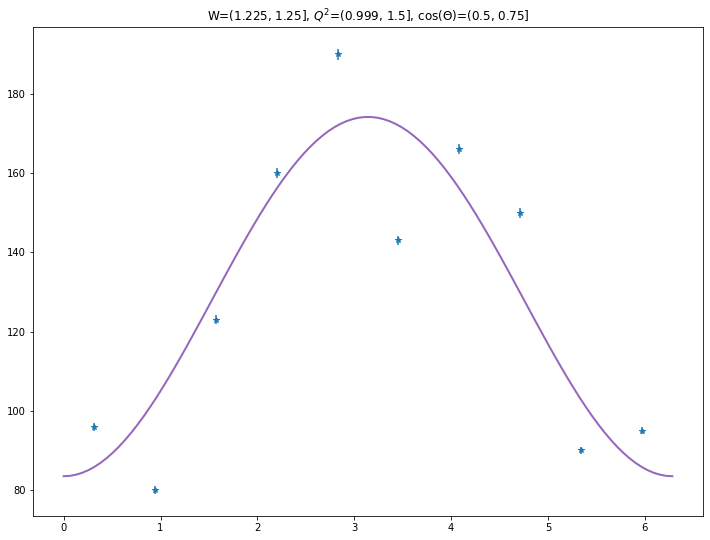

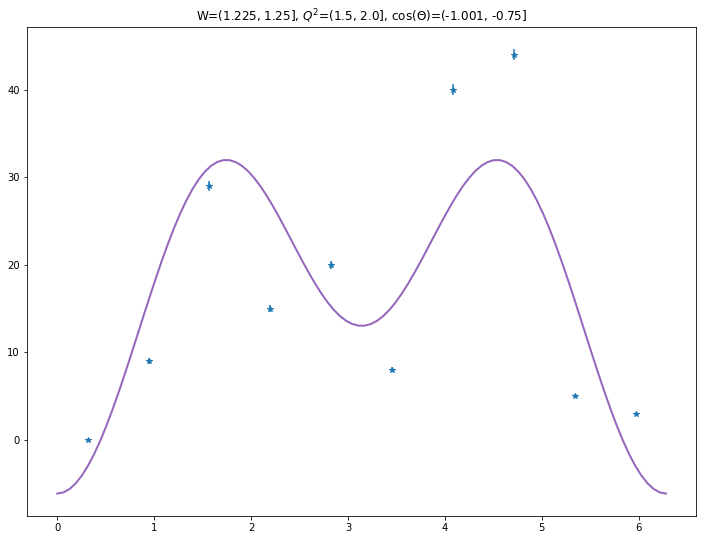

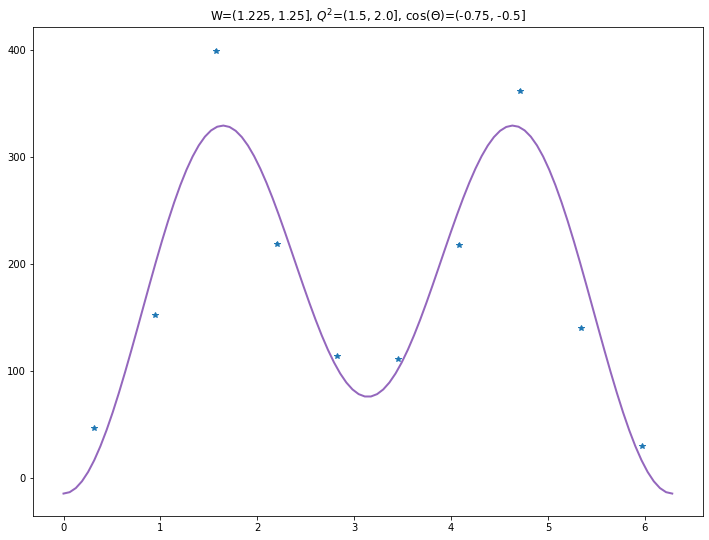

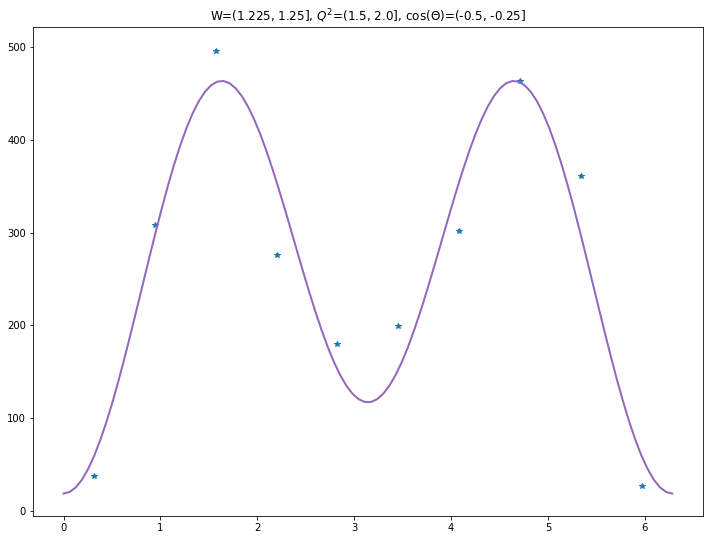

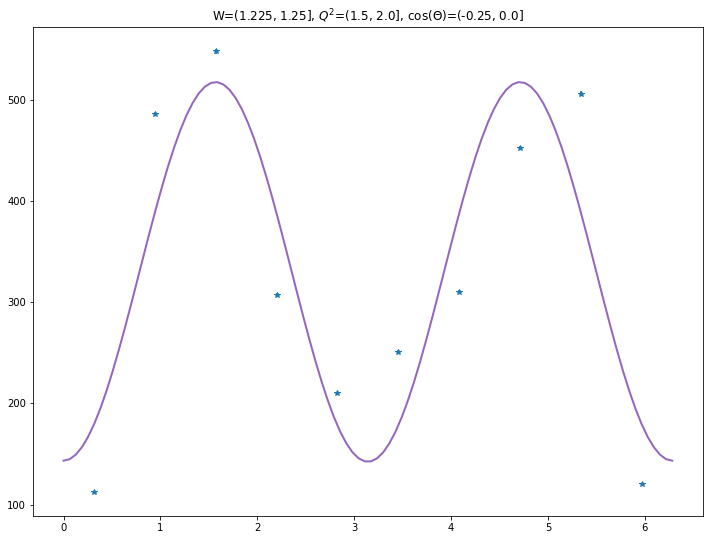

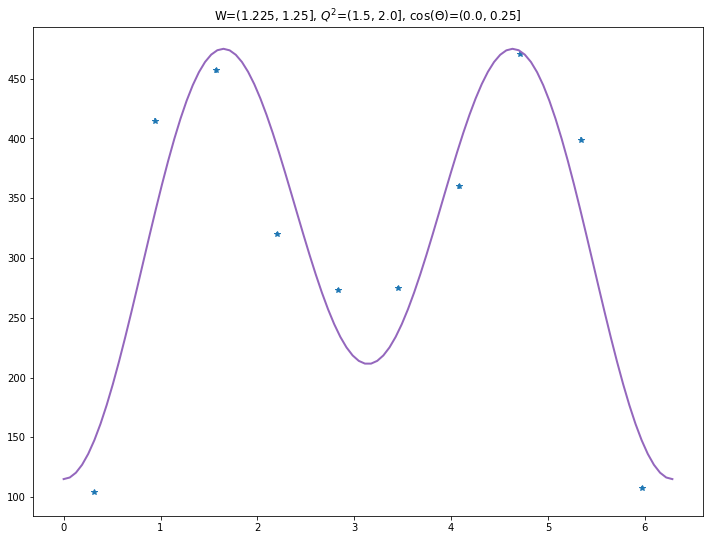

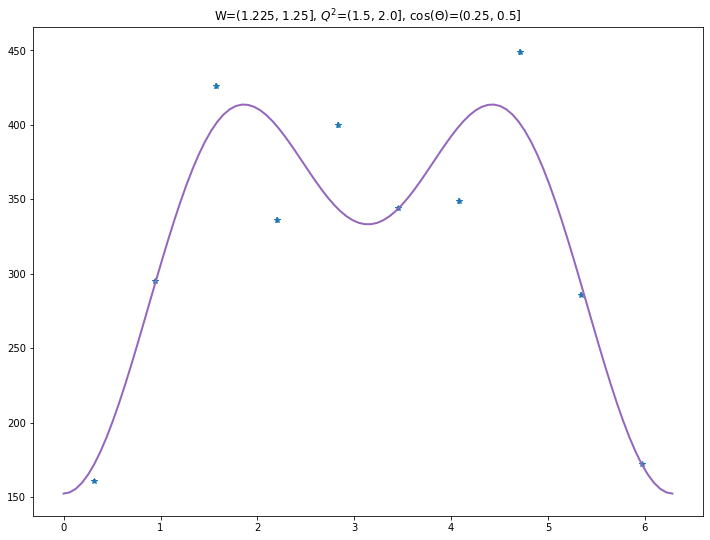

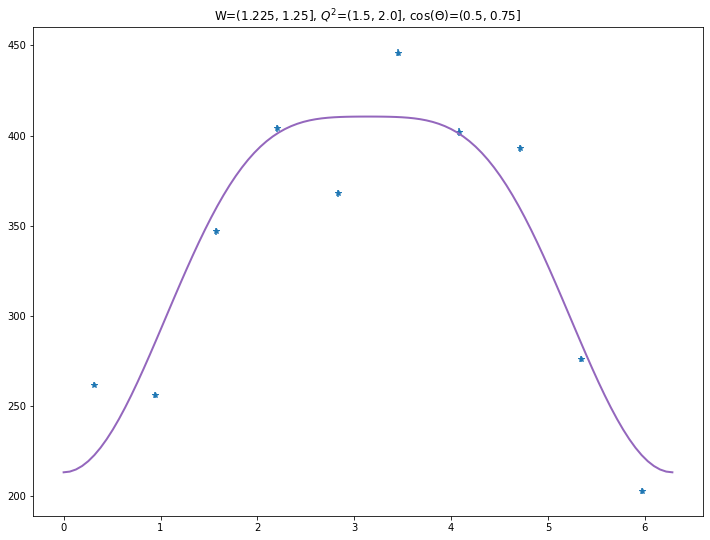

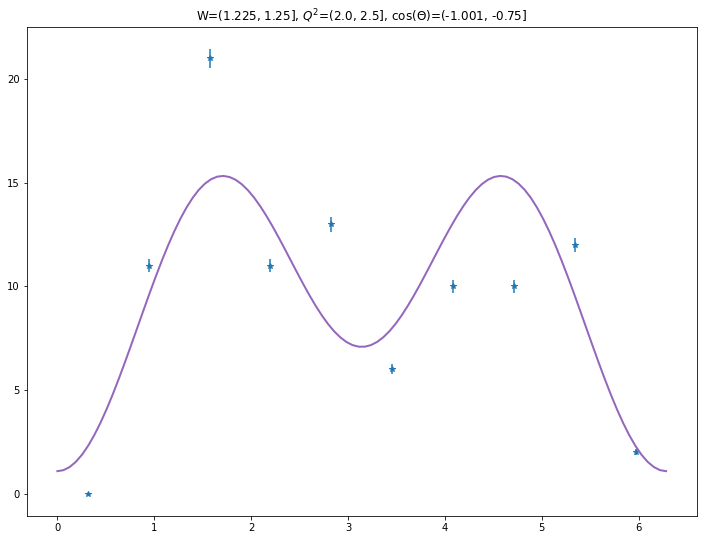

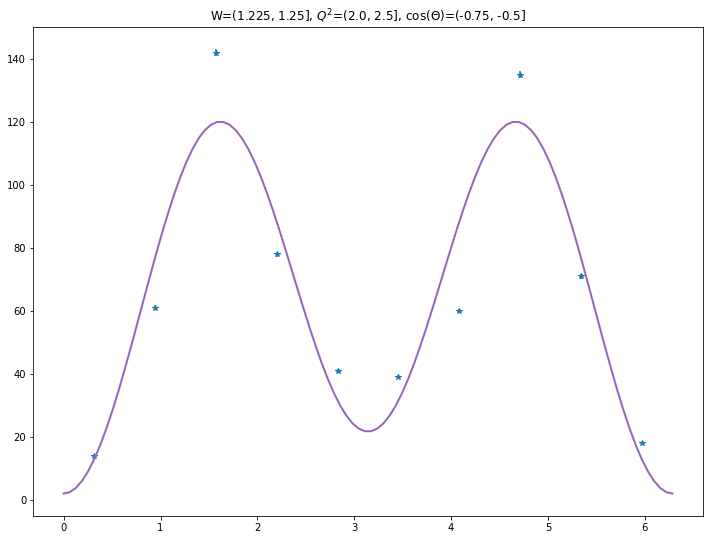

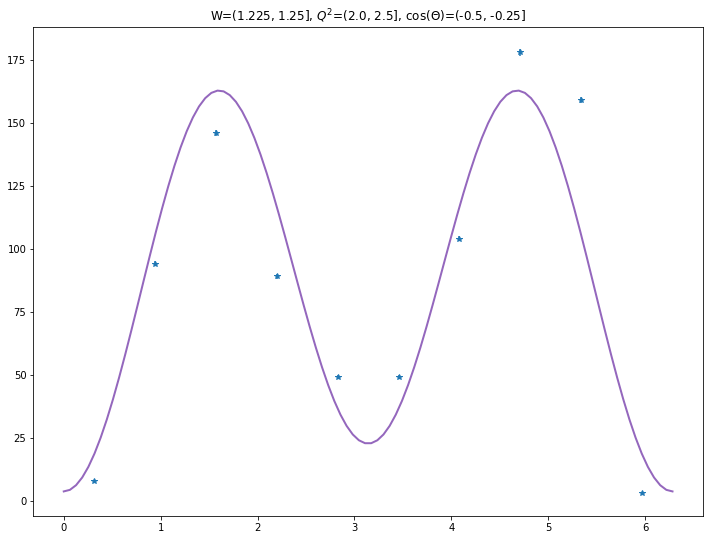

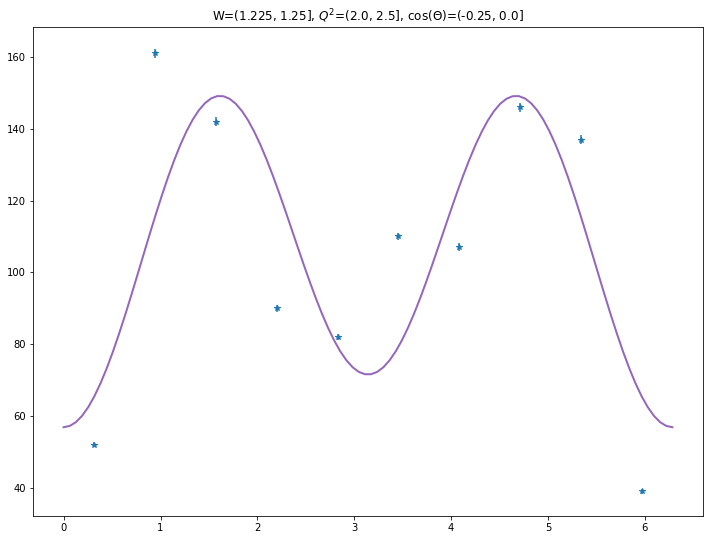

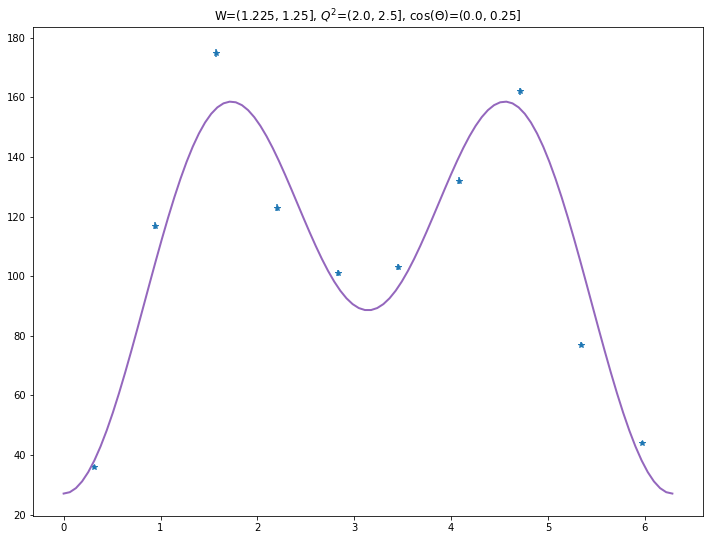

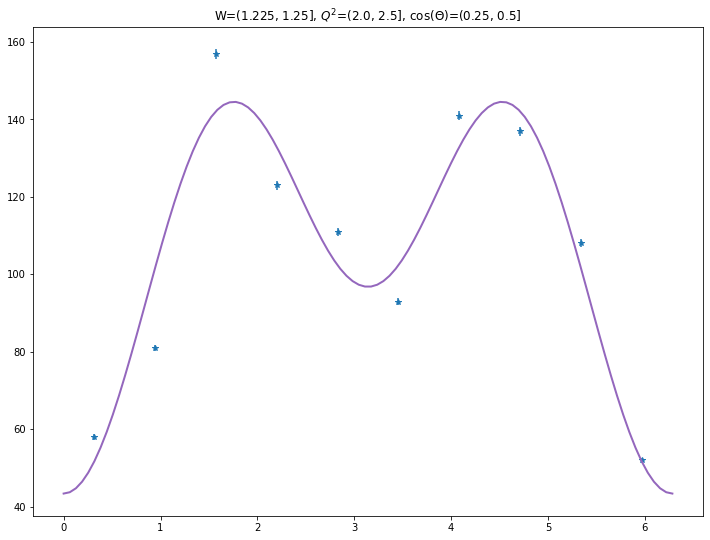

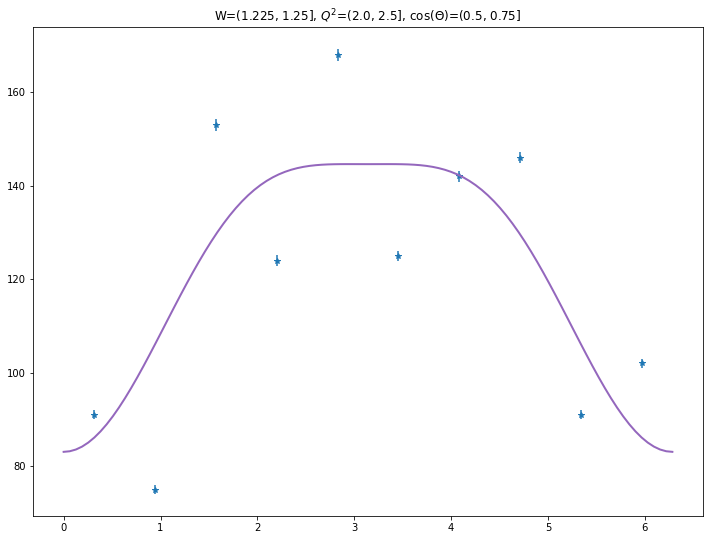

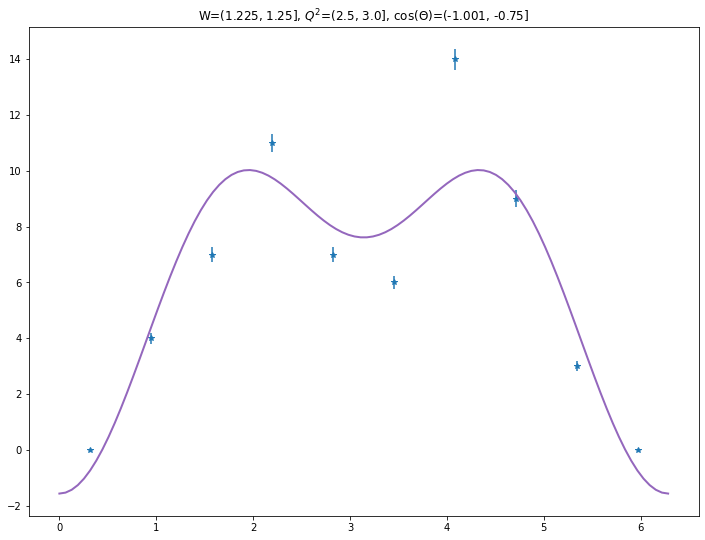

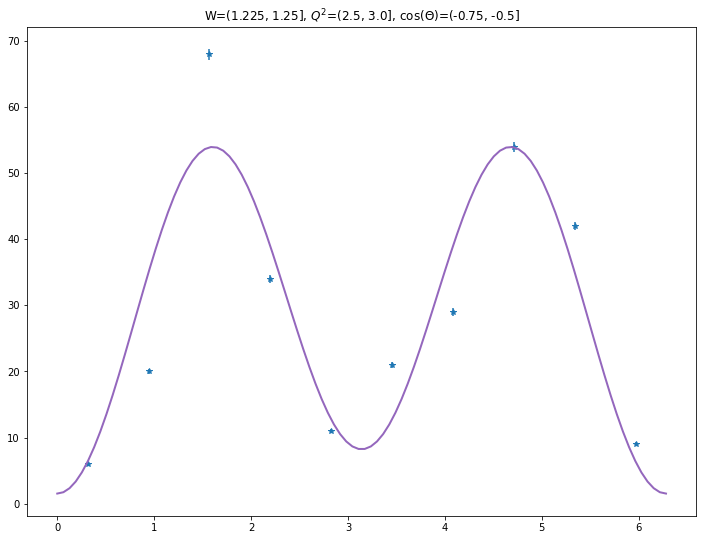

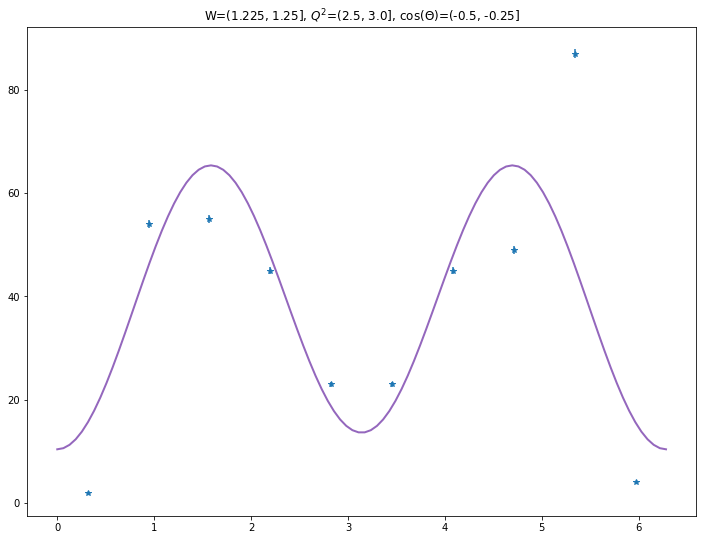

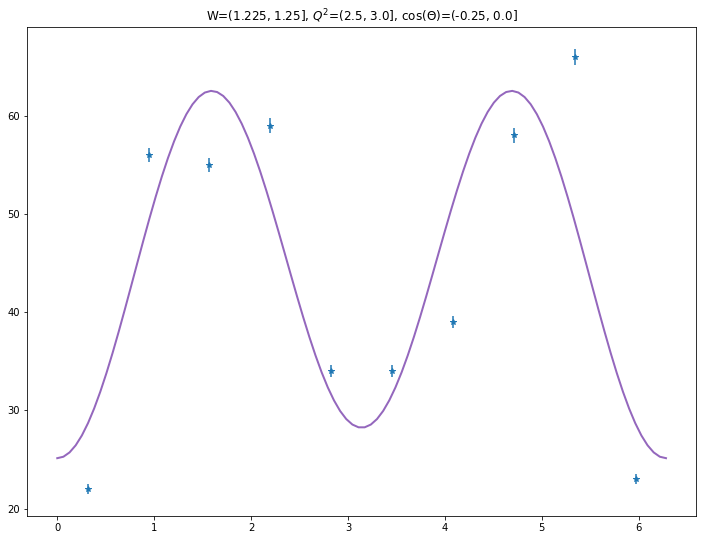

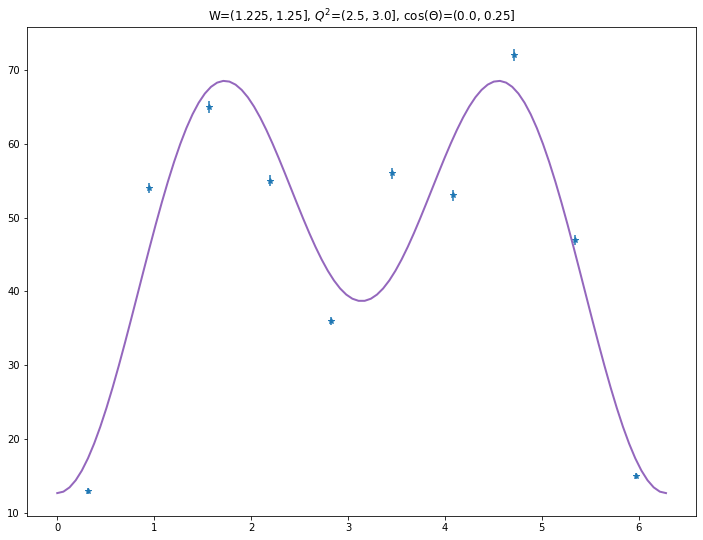

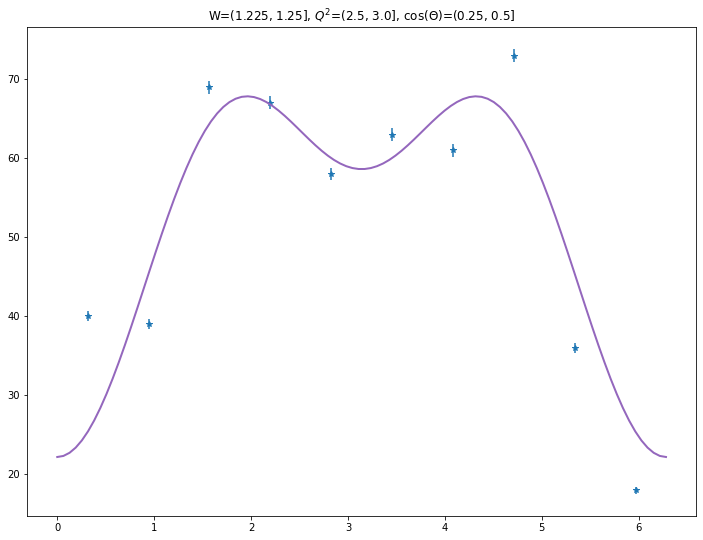

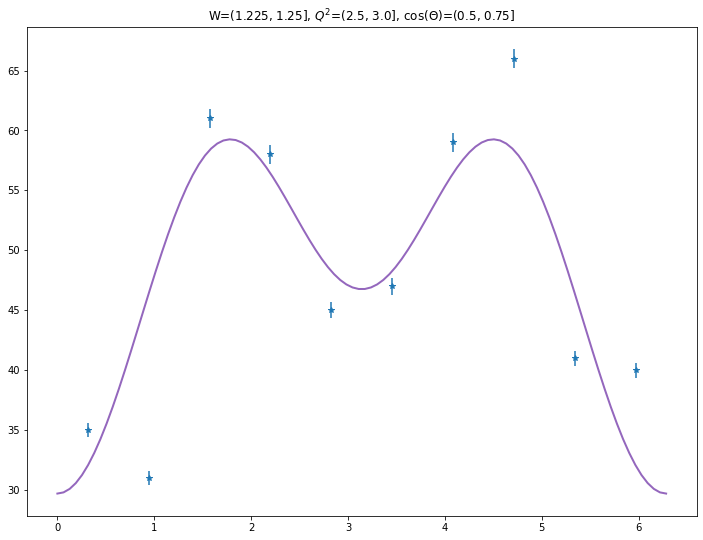

In [16]:
draw_xsection(cross_sections, model)